<a href="https://colab.research.google.com/github/tirthasheshpatel/OOP-in-Python/blob/master/Performance_Review_PyMC3%2C_PyMC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
cd /content/

REPONAME="pymc4"
REPO="https://github.com/tirthasheshpatel/pymc4.git"
BRANCH="add-mean"
FILES=`ls -la`
FLAG=0

for file in $FILES
do
    if [[ $file == $REPONAME ]]
    then
        cd $REPONAME
        git checkout $BRANCH
        git pull origin $BRANCH
        FLAG=1
        break
    fi
done

if [[ $FLAG -eq 0 ]]
then
    git clone $REPO
    cd $REPONAME
    git checkout $BRANCH
fi

pip install -r requirements.txt
pip install -r requirements-dev.txt
pip install arviz

Already on 'add-mean'
Your branch is up to date with 'origin/add-mean'.
From https://github.com/tirthasheshpatel/pymc4
 * branch            add-mean   -> FETCH_HEAD
Already up to date.


In [2]:
%tensorflow_version 2.x
%cd /content/pymc4
import pymc4 as pm4
import pymc3 as pm3
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import jax
import matplotlib.pyplot as plt
tfd = tfp.distributions

/content/pymc4


In [3]:
X, Xnew = np.random.randn(1000, 2), np.random.randn(100, 2)
gp = pm3.gp.Latent(cov_func=pm3.gp.cov.ExpQuad(1, 0.2))

with pm3.Model() as model:
    f = gp.prior('f', X)
    trace = pm3.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_]
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 258.02draws/s]


In [4]:
trace['f'].shape

(2000, 1000)

In [0]:
# gp = pm3.gp.Latent(cov_func=pm3.gp.cov.ExpQuad(1, 1.))
# with pm3.Model() as model:
#     f = gp.prior('f', X)
#     fcond = gp.conditional('fcond', Xnew)
#     trace = pm3.sample(1000)

In [0]:
gpu_device = tf.test.gpu_device_name()

In [7]:
import time
gp = pm4.gp.LatentGP(cov_fn=pm4.gp.cov.ExpQuad(1.))

@pm4.model
def gpmodel(gp, X):
    f = yield gp.prior('f', X)

model = gpmodel(gp, X.astype('float32'))

with tf.device(gpu_device):
    start = time.time()
    trace = pm4.sample(model, num_samples=1000, num_chains=2, xla=True)
    print(f"Sampling took: {time.time()-start:.4f} seconds")
trace.posterior['gpmodel/f']

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Sampling took: 194.1529 seconds


<xarray.DataArray 'gpmodel/f' (chain: 2, draw: 1000, gpmodel/f_dim_0: 1000)>
array([[[ 3.6127707e-01,  9.5410444e-02, -3.1088879e-03, ...,
          4.2141917e-01, -6.7246300e-01,  8.5052770e-01],
        [ 3.7712815e-01,  1.3823746e-01,  2.8344123e-02, ...,
          4.1172147e-01, -6.8495524e-01,  8.5862148e-01],
        [ 3.6511514e-01,  9.1380030e-02, -4.5792345e-04, ...,
          3.9900720e-01, -6.8138933e-01,  8.4801972e-01],
        ...,
        [ 3.3531874e-01,  1.0329126e-01,  8.6789563e-02, ...,
          4.9687508e-01, -6.1947155e-01,  7.5206864e-01],
        [ 3.6160704e-01,  8.5232757e-02,  7.1637854e-02, ...,
          4.9896419e-01, -6.2548643e-01,  7.6800746e-01],
        [ 3.1338578e-01,  1.0315565e-01,  6.7993782e-02, ...,
          4.8352358e-01, -6.2343013e-01,  7.6442730e-01]],

       [[ 7.2782451e-01,  7.5650162e-01,  6.3807440e-01, ...,
         -8.5587241e-02, -1.5975694e-01, -3.5406631e-01],
        [ 7.1510357e-01,  7.5731707e-01,  6.2969595e-01, ...,
         -6.7661472e-02, -1.5599220e-01, -3.8518968e-01],
        [ 7.2118092e-01,  7.6544213e-01,  6.4778125e-01, ...,
         -9.7759359e-02, -1.5405913e-01, -3.6682561e-01],
        ...,
        [ 6.2504190e-01,  7.4692601e-01,  6.2333953e-01, ...,
         -1.1199346e-01, -9.1800526e-02, -5.8504015e-01],
        [ 6.6236347e-01,  7.4773878e-01,  6.1571544e-01, ...,
         -1.3143097e-01, -8.2279883e-02, -5.5191815e-01],
        [ 6.1869949e-01,  7.5957417e-01,  6.2403470e-01, ...,
         -9.8080777e-02, -9.5311582e-02, -5.7545507e-01]]], dtype=float32)
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * gpmodel/f_dim_0  (gpmodel/f_dim_0) int64 0 1 2 3 4 5 ... 995 996 997 998 999

In [8]:
trace.posterior['gpmodel/f'].values.shape

(2, 1000, 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


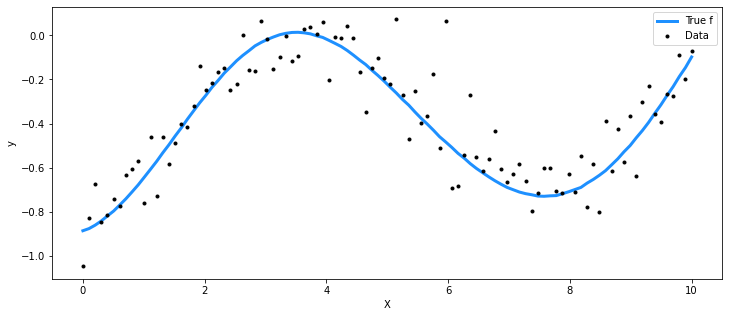

In [9]:
# set the seed
np.random.seed(42)

n = 100 # The number of data points
X = np.linspace(0, 10, n, dtype='float32')[:, None] # The inputs to the GP, they must be arranged as a column vector
n_new = 200
X_new = np.linspace(0, 15, n_new, dtype='float32')[:,None]

# Define the true covariance function and its parameters
l_true = 3.
cov_func = pm4.gp.cov.ExpQuad(amplitude=1., length_scale=l_true, feature_ndims=1)

# A mean function that is zero everywhere
mean_func = pm4.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
f_true = np.random.multivariate_normal(mean_func(X).numpy(), 
                                       cov_func(X, X).numpy() + 1e-6*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The degrees of freedom is `nu`
ν_true = 10.0
y = f_true + 0.1*np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, 'ok', ms=3, label="Data")
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [0]:
# with pm3.Model() as model:
#     ℓ = pm3.Gamma("ℓ", alpha=2, beta=1)
#     η = pm3.HalfCauchy("η", beta=5)

#     cov = η**2 * pm3.gp.cov.Matern52(1, ℓ)
#     gp = pm3.gp.Latent(cov_func=cov)

#     f = gp.prior("f", X=X)
#     f_pred = gp.conditional("f_pred", Xnew)

#     σ = pm3.HalfCauchy("σ", beta=5)
#     ν = pm3.Gamma("ν", alpha=2, beta=0.1)
#     y_ = pm3.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

#     trace = pm3.sample(1000, chains=1)

In [0]:
@pm4.model
def latent_gp_model(X, y, X_new):
    """A latent GP model with unknown length_scale and student-t noise

    Parameters
    ----------
    X: np.ndarray, tensor
        The prior data
    y: np.ndarray, tensor
        The function coressponding to the prior data
    X_new: np.ndarray, tensor
        The new data points to evaluate the conditional

    Returns
    -------
    y_pred: tensor
        Random sample from inferred function and its noise.
    """
    # We define length_scale of RBF kernel as a random variable
    l = yield pm4.HalfCauchy("l", scale=5.)
    # We can now define a GP with mean as zeros and covariance function
    # as RBF kernel with ``length_scale=l`` and ``amplitude=1``
    cov_fn = pm4.gp.cov.ExpQuad(length_scale=l, amplitude=1., feature_ndims=1)
    latent_gp = pm4.gp.LatentGP(cov_fn=cov_fn)
    # f is the prior and f_pred is the conditional which we discussed in theory section
    f = yield latent_gp.prior("f", X=X)
    f_pred = yield latent_gp.conditional("f_pred", X_new, given={'X': X, 'f': f})
    # finally, we model the noise and our outputs.
    ν = yield pm4.Gamma("ν", concentration=1., rate=0.1)
    y_pred = yield pm4.StudentT("y_pred", loc=f, scale=0.1, df=ν, observed=y)
    return y_pred

In [12]:
model = latent_gp_model(X, y, X_new)
with tf.device(gpu_device):
    start = time.time()
    trace = pm4.sample(model, num_samples=1000, num_chains=2, xla=True)
    print(f"Sampling took: {time.time()-start:.4f} seconds")
trace.posterior['latent_gp_model/f_pred']

Sampling took: 546.1245 seconds


<xarray.DataArray 'latent_gp_model/f_pred' (chain: 2, draw: 1000, latent_gp_model/f_pred_dim_0: 200)>
array([[[-9.0270972e-01, -8.9655781e-01, -8.6526614e-01, ...,
         -4.6339657e-02, -1.8066131e-02, -2.3473086e-02],
        [-9.0425092e-01, -8.6206853e-01, -8.4536207e-01, ...,
         -1.7624328e-02, -2.9288037e-02, -1.7691674e-02],
        [-9.2106104e-01, -8.6913908e-01, -8.6527860e-01, ...,
         -1.9740237e-02, -1.7184172e-02, -1.0111579e-03],
        ...,
        [-9.9788201e-01, -9.8032892e-01, -9.5184773e-01, ...,
         -2.6535740e-01, -3.0253908e-01, -3.4865326e-01],
        [-9.7807205e-01, -9.5157838e-01, -9.2220551e-01, ...,
         -2.0981996e-01, -2.5142288e-01, -2.8318000e-01],
        [-9.5843488e-01, -9.5199120e-01, -9.3527699e-01, ...,
         -2.4033083e-01, -2.6500195e-01, -2.9000118e-01]],

       [[-8.7952530e-01, -8.8508976e-01, -8.4988618e-01, ...,
          4.2401028e-01,  3.7268960e-01,  3.5092303e-01],
        [-9.0330797e-01, -9.0729588e-01, -8.6888671e-01, ...,
          3.9229134e-01,  3.2537997e-01,  3.0627355e-01],
        [-8.8860404e-01, -8.9532393e-01, -8.7259239e-01, ...,
          3.9166820e-01,  3.5047710e-01,  2.7994370e-01],
        ...,
        [-9.5004272e-01, -9.1968727e-01, -8.8024551e-01, ...,
          1.1889040e+00,  1.1834075e+00,  1.1929032e+00],
        [-9.3701565e-01, -9.1402960e-01, -8.7799734e-01, ...,
          1.1702569e+00,  1.1542521e+00,  1.1610924e+00],
        [-8.9410251e-01, -8.7320292e-01, -8.7491196e-01, ...,
          1.1369017e+00,  1.1497186e+00,  1.0979121e+00]]], dtype=float32)
Coordinates:
  * chain                         (chain) int64 0 1
  * draw                          (draw) int64 0 1 2 3 4 ... 995 996 997 998 999
  * latent_gp_model/f_pred_dim_0  (latent_gp_model/f_pred_dim_0) int64 0 ... 199

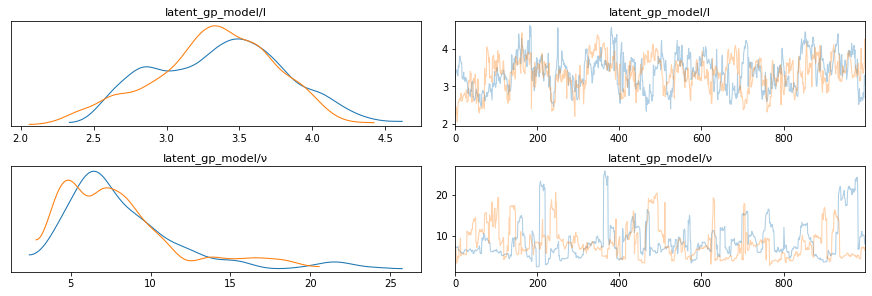

In [13]:
import arviz as az
az.plot_trace(trace, var_names=["latent_gp_model/l", "latent_gp_model/ν"]);

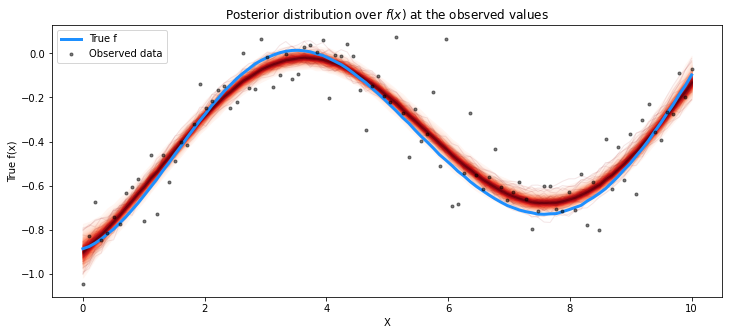

In [14]:
from pymc4.plots import plot_gp_dist

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, np.array(trace.posterior["latent_gp_model/f"])[1], X)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [0]:
# @tf.function
# def gp_model(inputs, optimizer):
#     sigma, mu, y = inputs
#     with tf.GradientTape() as tape:
#         neg_log_like = 1./2. * tf.math.log(tf.linalg.det(sigma)) + tf.linalg.matrix_transpose(y - mu) * tf.linalg.inv(sigma) * (y - mu)
#     grads = tape.gradient(neg_log_like, [mu])
#     optimizer.apply_gradients(zip(grads, [mu]))
#     neg_log_like = 1./2. * tf.math.log(tf.linalg.det(sigma)) + tf.linalg.matrix_transpose(y - mu) * tf.linalg.inv(sigma) * (y - mu)
#     return mu, neg_log_like

In [0]:
# y = np.random.randn(100, 1)
# mu = np.array([3.])
# sigma = np.array([[1.]])
# gp_model((sigma, mu, y), tf.keras.optimizers.SGD(learning_rate=0.1))

In [0]:
# !pip install arviz
# from google.colab import files
# uploaded = files.upload()
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import arviz as az
# import warnings
# warnings.filterwarnings("ignore")


# class MyMean(pm.gp.mean.Mean):
#     def __init__(self, alpha, beta0, beta1):
#         self.alpha = alpha
#         self.beta0 = beta0
#         self.beta1 = beta1

#     def __call__(self, X):
#         hypothesis = self.alpha + self.beta0 * X[:, 0] + self.beta1 * X[:, 1]
#         return hypothesis


# # load your data
# walker_data = pd.read_table('walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
# X = walker_data[['Xloc', 'Yloc']].values
# y = walker_data["V"].values
# # X = np.random.randn(100, 2)
# # y = 2. + 1. * X[:, 0] + 2. * X[:, 1] + .5 * np.random.randn(100)
# with pm.Model() as model:
#     # set the priors over our hyper-parameters
#     ls = pm.Normal('ls', mu=1., sigma=10.)                      # length scale (covariance function param)
#     amplitude = pm.HalfStudentT('amplitude', nu=50., sigma=2.)  # amplitude (covariance param)
#     sigma = pm.HalfCauchy('sigma', beta=.1)                     # sigma (gp noise param)
#     mean_hp = pm.Normal('alpha', mu=0., sigma=10., shape=3)     # alpha, beta0, beta1 (mean function param)

#     # create a mean and covariance function
#     mean_func = MyMean(mean_hp[0], mean_hp[1], mean_hp[2])
#     cov_func = amplitude * pm.gp.cov.ExpQuad(2, ls=ls)

#     # create the gp model
#     gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

#     # fit the gp over our data to get likelihood
#     like = gp.marginal_likelihood('like', X, y, noise=sigma)

# # now, we can sample from the likelihood to see
# # how good the model has fitted to our data
# with model:
#     trace = pm.sample(500, tune=500, chains=2)

# # let's see the performance
# az.plot_trace(trace)
# plt.show()

# y_preds, _ = gp.predictt(X)

# print(f"mse : {np.sum((y - y_preds) ** 2)}")